In [1]:
%load_ext autoreload
%autoreload 2
import gc
import sys

gc.collect()

paths_to_add = ['/home/jovyan/work', '/home/jupyter/alpha_media_signal']

for p in paths_to_add:
    if p not in sys.path:
        sys.path.append(p)

import pandas as pd

from ams.services.equities.EquityFundaDimension import EquityFundaDimension
%matplotlib inline
from pathlib import Path

from ams.config import constants
from ams.services import twitter_service
from ams.services import ticker_service

from statistics import mean
import numpy as np
from ams.services import file_services
from typing import List
from ams.notebooks.twitter.twitter_ml_utils import WorkflowMode
from ams.notebooks.twitter import twitter_ml_utils
from ams.utils import date_utils

pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

Setting up logging...
Will use logging path: C:\Users\Chris\workspaces\data\logs\alpha_media_signal


In [2]:
twitter_folder = 'twitter'

tr_file_path = Path(constants.TWITTER_OUTPUT_RAW_PATH, "tip_ranked", "main", "tip_rank_2020-12-14_22-48-27-354.17.parquet")

In [3]:
%%time

learning_prep_dir = Path(constants.TWITTER_GREAT_REDUCTION_DIR, "main")
df_twitter_raw = twitter_ml_utils.load_twitter_raw(learning_prep_dir=learning_prep_dir)

cat_uniques = None
model_xgb = None

workflow_mode = WorkflowMode.Prediction
# workflow_mode = WorkflowMode.Training
predict_date_str = "2020-10-26"
num_hold_days = 5

dt = date_utils.parse_std_datestring(predict_date_str)
if date_utils.is_stock_market_closed(dt):
    raise Exception("No can do. Market closed.")

if workflow_mode is WorkflowMode.Training:
    df_twitter_raw = df_twitter_raw[df_twitter_raw["date"] < predict_date_str]
else:
    print("Prediction.")
    #today_dt_str = date_utils.get_standard_ymd_format(datetime.now())
    df_twitter_raw = df_twitter_raw[df_twitter_raw["date"] == predict_date_str]
    model_xgb = twitter_ml_utils.load_model_for_prediction()
    cat_uniques = model_xgb.cat_uniques
    
print(f"Max date: {df_twitter_raw['date'].max()}")
print(f"Num records: {df_twitter_raw.shape[0]:,}")

Max date: 2020-10-25
Num records: 123,645
Wall time: 542 ms


Wall time: 390 ms


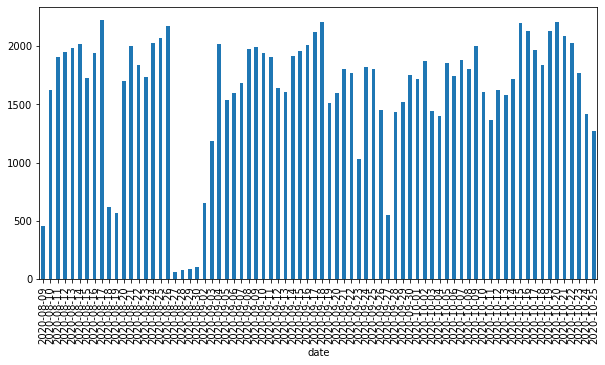

In [4]:
%%time 

twitter_ml_utils.show_distribution(df=df_twitter_raw)

In [5]:
%%time

df_booled = twitter_service.convert_to_bool(df=df_twitter_raw)

Wall time: 1.97 s


In [6]:
%%time

df_twitter = twitter_ml_utils.convert_twitter_to_numeric(df=df_booled)
df_twitter.head()

Wall time: 4 ms


,created_at,user_screen_name,favorite_count,in_reply_to_screen_name,user_verified,metadata_result_type,user_listed_count,user_time_zone,user_has_extended_profile,in_reply_to_status_id,user_statuses_count,user_protected,user_is_translation_enabled,user_location,lang,user_geo_enabled,place_country,place_name,possibly_sensitive,user_friends_count,retweet_count,user_follow_request_sent,user_followers_count,f22_ticker,f22_has_cashtag,f22_ticker_in_text,f22_num_other_tickers_in_tweet,f22_sentiment_pos,f22_sentiment_neu,f22_sentiment_neg,f22_sentiment_compound,f22_id,created_at_timestamp,date,f22_compound_score,f22_is_tweet_after_hours
147293,Sun Aug 09 21:03:19 +0000 2020,Maame_Afya,0.0,Agorkoli_,False,recent,2.000000,NaN,True,1.2925604792447386e+18,8544.0,False,False,nan,en,True,nan,nan,True,1947.750000,6.5,True,1277.750000,ELCO,True,True,0.500000,0.19975,0.800250,0.000000,0.406575,8698700209624637587,1.597007e+09,2020-08-09,773.793200,NaN
125360,Sun Aug 09 22:21:21 +0000 2020,EnterpriseLeade,0.0,nan,False,recent,100.333333,NaN,False,nan,577800,False,False,United States,en,False,nan,nan,False,18.333333,0.0,True,1830.000000,DCIX,True,True,0.666667,0.00000,1.000000,0.000000,0.000000,-2562322011414269413,1.597012e+09,2020-08-09,0.000000,NaN
103170,Mon Aug 10 00:15:56 +0000 2020,AmericanBanking,0.0,nan,False,recent,365.000000,NaN,False,nan,2698257.0,False,False,Sioux Falls&#44; SD,en,False,nan,nan,False,1066.000000,0.0,True,4026.500000,CNST,True,True,0.500000,0.09050,0.909500,0.000000,0.238350,5733206439605406186,1.597019e+09,2020-08-09,35.990850,NaN
456192,Sun Aug 09 17:37:53 +0000 2020,Atif_MyChannel,0.0,nan,False,recent,2.000000,NaN,False,nan,7463,False,False,nan,en,False,nan,nan,False,1813.666667,281.0,True,1725.333333,TROY,True,True,0.000000,0.10500,0.638667,0.256333,-0.306700,-6819472559233901419,1.596995e+09,2020-08-09,-1114.241733,NaN
193556,Sun Aug 09 21:00:45 +0000 2020,EarningsAlley,1.0,EarningsAlley,False,recent,10.000000,NaN,False,1.292566505780138e+18,23123,False,False,nan,en,False,nan,nan,True,1.000000,0.0,True,464.000000,GO,True,True,5.000000,0.00000,1.000000,0.000000,0.000000,332765547698948601,1.597007e+09,2020-08-09,0.000000,NaN


In [7]:
%%time

df_stock_data = twitter_ml_utils.get_twitter_stock_data(df_tweets=df_twitter, 
                                                        num_hold_days=num_hold_days, 
                                                        workflow_mode=workflow_mode)
df_stock_data.head()

Training
Wall time: 31.7 s


,ticker,date,open,high,low,close,volume,dividends,closeunadj,lastupdated,future_open,future_low,future_high,future_close,future_date,None
2921,AAL,2020-08-11,15.02,15.10,13.55,13.73,126759332.0,0.0,13.73,2020-08-11,12.600,12.51,12.88,12.60,2020-08-18,NaN
2922,AAL,2020-08-12,14.03,14.06,13.10,13.54,77075223.0,0.0,13.54,2020-08-12,12.650,12.58,13.44,12.68,2020-08-19,NaN
2923,AAL,2020-08-13,13.19,13.90,13.11,13.30,47397842.0,0.0,13.30,2020-08-13,12.380,12.26,12.67,12.50,2020-08-20,NaN
2924,AAL,2020-08-14,13.11,13.56,13.01,13.33,45670200.0,0.0,13.33,2020-08-14,12.438,12.09,12.63,12.16,2020-08-21,NaN
2925,AAL,2020-08-17,13.32,13.38,12.61,12.62,55705663.0,0.0,12.62,2020-08-17,12.440,12.27,13.48,13.44,2020-08-24,NaN


In [8]:
# %%time

df_rec_quart_drop = twitter_service.get_all_quarterly_data_for_twitter()

columns_fundy = list(df_rec_quart_drop.columns)

In [9]:
%%time

df_result = twitter_ml_utils.merge_fundies_with_stock(df_stock_data=df_stock_data)
df_result.head()


Wall time: 7.41 s


,ticker,dimension,calendardate,datekey,reportperiod,lastupdated,accoci,assets,assetsavg,assetsc,assetsnc,assetturnover,bvps,capex,cashneq,cashnequsd,cor,consolinc,currentratio,de,debt,debtc,debtnc,debtusd,deferredrev,depamor,deposits,divyield,dps,ebit,ebitda,ebitdamargin,ebitdausd,ebitusd,ebt,eps,epsdil,epsusd,equity,equityavg,equityusd,ev,evebit,evebitda,fcf,fcfps,fxusd,gp,grossmargin,intangibles,intexp,invcap,invcapavg,inventory,investments,investmentsc,investmentsnc,liabilities,liabilitiesc,liabilitiesnc,marketcap,ncf,ncfbus,ncfcommon,ncfdebt,ncfdiv,ncff,ncfi,ncfinv,ncfo,ncfx,netinc,netinccmn,netinccmnusd,netincdis,netincnci,netmargin,opex,opinc,payables,payoutratio,pb,pe,pe1,ppnenet,prefdivis,price,ps,ps1,receivables,retearn,revenue,revenueusd,rnd,roa,roe,roic,ros,sbcomp,sgna,sharefactor,sharesbas,shareswa,shareswadil,sps,tangibles,taxassets,taxexp,taxliabilities,tbvps,workingcapital,date,open,high,low,close,volume,dividends,closeunadj,lastupdated_eq_fun,future_open,future_low,future_high,future_close,future_date,None
0,A,ARQ,2015-03-31,2015-06-05,2015-04-30,2020-09-01,-270000000.0,7.412000e+09,NaN,3.620000e+09,3.792000e+09,NaN,12.449,-9000000.0,2.197000e+09,2.197000e+09,483000000.0,83000000.0,3.892,0.782,1.656000e+09,0.0,1.656000e+09,1.656000e+09,271000000.0,63000000.0,0.0,0.400,0.100,108000000.0,171000000.0,0.178,171000000.0,108000000.0,91000000.0,0.25,0.25,0.25,4.158000e+09,NaN,4.158000e+09,1.288996e+10,24.0,15.129,174000000.0,0.521,1.0,480000000.0,0.498,2.857000e+09,17000000.0,3.084000e+09,NaN,556000000.0,91000000.0,0.0,91000000.0,3.251000e+09,9.300000e+08,2.321000e+09,1.343096e+10,0.000000e+00,2000000.0,-130000000.0,0.0,-33000000.0,-101000000.0,-7000000.0,0.0,183000000.0,4000000.0,83000000.0,83000000.0,83000000.0,5000000.0,0.0,0.086,373000000.0,107000000.0,261000000.0,0.400,3.230,41.326,41.557,593000000.0,0.0,40.31,2.416,2.421,576000000.0,5.397000e+09,9.630000e+08,9.630000e+08,81000000.0,NaN,NaN,NaN,NaN,11000000.0,292000000.0,1.0,333191751.0,334000000.0,337000000.0,2.883,4.555000e+09,0.0,8000000.0,0.0,13.638,2.690000e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,A,ARQ,2015-06-30,2015-09-02,2015-07-31,2020-09-01,-332000000.0,7.251000e+09,NaN,3.478000e+09,3.773000e+09,NaN,12.358,-19000000.0,2.075000e+09,2.075000e+09,501000000.0,103000000.0,4.077,0.767,1.655000e+09,0.0,1.655000e+09,1.655000e+09,265000000.0,62000000.0,0.0,0.453,0.100,143000000.0,205000000.0,0.202,205000000.0,143000000.0,126000000.0,0.31,0.31,0.31,4.103000e+09,NaN,4.103000e+09,1.135476e+10,25.0,15.200,72000000.0,0.217,1.0,513000000.0,0.506,2.850000e+09,17000000.0,3.128000e+09,NaN,545000000.0,88000000.0,0.0,88000000.0,3.145000e+09,8.530000e+08,2.292000e+09,1.177476e+10,0.000000e+00,-66000000.0,-82000000.0,0.0,-33000000.0,-110000000.0,-87000000.0,-2000000.0,91000000.0,-16000000.0,103000000.0,103000000.0,103000000.0,2000000.0,0.0,0.102,369000000.0,144000000.0,248000000.0,0.323,2.870,41.903,42.298,587000000.0,0.0,35.53,2.449,2.453,584000000.0,5.474000e+09,1.014000e+09,1.014000e+09,79000000.0,NaN,NaN,NaN,NaN,5000000.0,290000000.0,1.0,331403231.0,332000000.0,334000000.0,3.054,4.401000e+09,0.0,23000000.0,0.0,13.256,2.625000e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,A,ARQ,2015-09-30,2015-12-21,2015-10-31,2020-09-01,-391000000.0,7.479000e+09,NaN,3.686000e+09,3.793000e+09,NaN,12.627,-26000000.0,2.245000e+09,2.245000e+09,500000000.0,143000000.0,3.777,0.794,1.655000e+09,0.0,1.655000e+09,1.655000e+09,258000000.0,60000000.0,0.0,0.010,0.100,159000000.0,219000000.0,0.212,219000000.0,159000000.0,143000000.0,0.43,0.43,0.43,4.167000e+09,NaN,4.167000e+09,1.297254e+10,25.0,17.024,211000000.0,0.639,1.0,535000000.0,0.517,2.811000e+09,16000000.0,3.102000e+09,NaN,541000000.0,86000000.0,0.0,86000000.0,3.309000e+09,9.760000e+08,2.333000e+09,1.356254e+10,-1.026000e+09,-8000000.0,1000000.0,0.0,-33000000.0,-29000000.0,-275000000.0,-240000000.0,237000000.0,-5000000.0,143000000.0,143000000.0,143000000.0,0.0,0.0,0.138,379000000.0,156000000.0,279

In [10]:
df_drop_init = df_result.dropna(subset=["date"]).drop(columns="lastupdated_eq_fun")

df_drop_future = df_drop_init[df_drop_init["date"] > df_drop_init["calendardate"]]

df_drop_future = df_drop_future.sort_values(by=["ticker", "date", "calendardate"], ascending=False)

df_stock_and_quarter = df_drop_future.drop_duplicates(subset=["ticker", "date"], keep="first")

# df_stock_and_quarter.shape[0]
df_drop_init.shape[0]

1183105

In [11]:
df_nas_tickers_info, cat_uniques = ticker_service.get_nasdaq_tickers(cat_uniques=cat_uniques)

c:\programdata\miniconda3\envs\alpha_media_signal\lib\site-packages\pandas\core\indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
c:\programdata\miniconda3\envs\alpha_media_signal\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [12]:
%time

col_ticker = "ticker_drop"

df_stock_quart_info = pd.merge(df_stock_and_quarter, df_nas_tickers_info, how='inner', left_on=["ticker"], right_on=[col_ticker])
df_sqi = df_stock_quart_info.drop(columns=[col_ticker])

df_sqi.shape[0]

Wall time: 0 ns


112102

In [13]:
%%time

df_stock_renamed = df_sqi.rename(columns={"ticker": "f22_ticker"})

if 'None' in df_stock_renamed.columns:
    df_stock_renamed = df_stock_renamed.drop(columns=['None'])

df_merged = pd.merge(df_twitter, df_stock_renamed, how='inner', left_on=["f22_ticker","date"], right_on=["f22_ticker","date"])

print(f'Num merged: {df_merged.shape[0]}')

Num merged: 112102
Wall time: 1.25 s


In [14]:
df_days = twitter_ml_utils.add_days_since_quarter_results(df=df_merged)

Num rows in play: 112102


In [15]:
df_days["future_date"].max()

'2020-10-29'

In [16]:
%%time

df_days_of = twitter_ml_utils.add_calendar_days(df=df_days)

df_days_of["future_date"].max()

Wall time: 7.41 s


'2020-10-29'

In [17]:
%%time

df_dd = twitter_ml_utils.add_nasdaq_roi(df=df_days_of)

Wall time: 1.59 s


In [18]:
%%time

if workflow_mode == WorkflowMode.Training:
    df_thin_rabbit = twitter_service.add_buy_sell(df=df_dd)
else:
    df_thin_rabbit = df_dd

Wall time: 129 ms


In [19]:
df_thin_rabbit["original_close_price"] = df_thin_rabbit["close"]
df_thin_rabbit["date"].max()
print(f'Num df_thin_rabbit: {df_thin_rabbit.shape[0]}')

Num df_thin_rabbit: 56051


In [20]:
# save_twitter_stock_join(df=df_thin_rabbit)

In [21]:
%%time
cols_fundy_numeric = list(set(columns_fundy) - {"ticker", 'calendardate', 'datekey', 'reportperiod'})

df_no_z = twitter_service.fill_null_numeric(df=df_thin_rabbit, cols_fundy_numeric=cols_fundy_numeric)

Wall time: 194 ms


In [22]:
%%time
    
df_since_sma = twitter_ml_utils.add_sma_stuff(df=df_no_z)

Wall time: 1min 14s


In [23]:
%%time

df_since_sma["purchase_date"] = df_since_sma["date"]

Wall time: 1e+03 µs


In [24]:
%%time

df_days_until = ticker_service.add_days_until_sale(df=df_since_sma)

Wall time: 2.06 s


In [25]:
%%time
df = twitter_service.refine_pool(df=df_days_until, min_volume=None, min_price=None, max_price=None)
df = twitter_service.omit_columns(df=df)
df_tweet_counted = twitter_service.add_tweet_count(df=df).drop(columns=["calendardate", "reportperiod", "dimension", "datekey"])

Wall time: 11.3 s


In [26]:
df_tweet_counted["future_date"].max()

'2020-10-29'

In [27]:
# df_winnowed = twitter_ml_utils.truncate_avail_columns(df=df_tweet_counted)

In [28]:
print(df_tweet_counted.shape[0])

df_ranked = twitter_ml_utils.add_tip_ranks(df=df_tweet_counted, tr_file_path=tr_file_path)

56051


In [29]:
df_ranked["future_date"].max()

'2020-10-29'

In [30]:
print(df_ranked.shape[0])

df_ticker_hotted, unique_tickers = ticker_service.make_f22_ticker_one_hotted(df_ranked=df_ranked, cat_uniques=cat_uniques)

cat_uniques["f22_ticker"] = unique_tickers
print(f"{len(cat_uniques['f22_ticker'])}")

narrow_cols = list(df_ticker_hotted.columns)

56051
cat_uniques is not used.
2221


In [31]:
%%time

df_train = df_ticker_hotted

print(df_train.shape[0])
print(df_train["future_date"].max())
print(len(cat_uniques["f22_ticker"]))

if workflow_mode is WorkflowMode.Training:
    # sac_roi_list = twitter_ml_utils.find_ml_pred_perf(df=df_train)
#     sac_roi_list = twitter_ml_utils.torch_non_linear(df=df_train, narrow_cols=narrow_cols)
    sac_roi_list = twitter_ml_utils.xgb_learning(df=df_train, narrow_cols=narrow_cols, cat_uniques=cat_uniques)    

56051
2020-10-29
2221
Split | min: 2020-08-10 | max: 2020-10-22
Split dates for small dataset: ['2020-10-21', '2020-10-22']
Original: 56051; train_set: 54715; val_set: 1336


C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Mean: 0.18840579710144928
Avg investment per trade: 90.28276167471824
Roi per trade: -0.0287
Num trades: 621 | acc: 0.21256 | s@close roi: 0.020462912708200613 | s@high roi: 0.011052
Sell high/close roi@0.07: -0.038775; weight: -24.079328069273302
Mean sac_roi: 0.020462912708200613

Overall mean s@close: 0.020462912708200613

Wall time: 1min 2s


In [32]:
if workflow_mode is WorkflowMode.Training: 
    startup_cash = 1000

    investment = startup_cash
    for s in sac_roi_list:
        investment = (investment * s) + investment

    print(f"roi amount: {investment}")
    print(sac_roi_list)

roi amount: 1020.4629127082006
[0.020462912708200613]


In [33]:
from ams.services import pickle_service
from datetime import datetime

overwrite_file = False
if workflow_mode is WorkflowMode.Prediction:
    def get_data_for_predictions(df: pd.DataFrame, narrow_cols: List[str]):
        feature_cols = twitter_service.get_feature_columns(narrow_cols)

        return np.array(df[feature_cols])

    X_predict = get_data_for_predictions(df=df_ticker_hotted, narrow_cols=narrow_cols)

    prediction = model_xgb.model.predict(X_predict)

    df_ticker_hotted["prediction"] = prediction
    
    df_buy = df_ticker_hotted[df_ticker_hotted["prediction"] == 1][["f22_ticker", "purchase_date"]]
    df_buy["num_hold_days"] = num_hold_days
    df_buy["run_timestamp"] = datetime.timestamp(datetime.now())
    
    print(df_buy.head(10))
    
    rows = df_buy.to_dict('records')

    from ams.services import csv_service
    csv_service.write_dicts_as_csv(output_file_path=constants.TWITTER_PREDICTIONS_PATH,
                                  overwrite=overwrite_file,
                                  rows=rows)